# Predict played action from frame sequences

In [1]:
import numpy as np           
import tensorflow as tf
import ourlib
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])  # n00bz who dont

Initialize basic environment

In [2]:
ourlib.init_basic_env()

Play episode randomly and return pre-processed frames

In [3]:
frames, labels = ourlib.play_episode()
len(frames)

/Users/tommasobiancalani/anaconda3/envs/py27-dqdoom/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/tommasobiancalani/anaconda3/envs/py27-dqdoom/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


300

Display some randomly-chosen frames and corresponding action performed. 

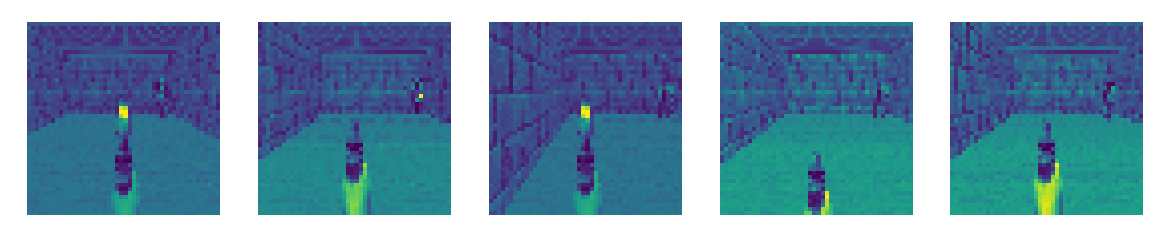

In [4]:
n_frames = 5
fig, axs = plt.subplots(ncols=n_frames, figsize=(20, 10))
ixs = list(np.random.choice(range(len(frames)), size=n_frames))
for ax,ix in zip(axs, ixs):
    ax.axis('off')
    ax.imshow(frames[ix])
    ax.set_title('Frame: ' + str(ix) + ' Action: ' + str(labels[ix]))

Display first frames

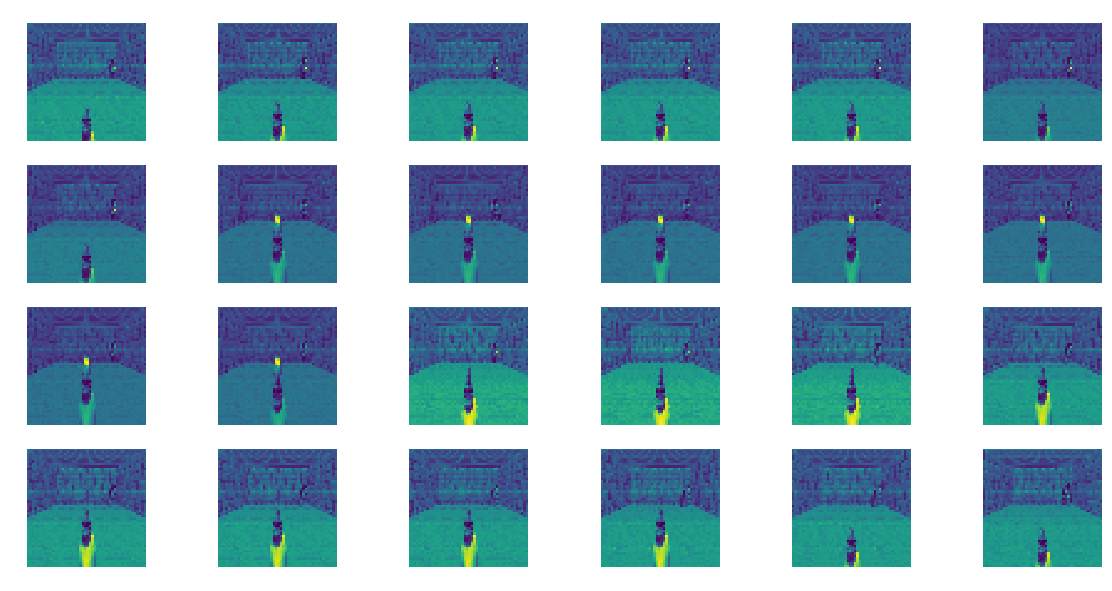

In [5]:
n_frames = 6 # per row
n_rows = 4
ixs = range(n_frames*n_rows)
fig, axs = plt.subplots(ncols=n_frames, nrows=n_rows, figsize=(20, 10))
for coord, ix in enumerate(ixs):
    coord = np.unravel_index(coord, dims=(n_rows, n_frames)) # there must be a simpler way
    axs[coord].axis('off')
    axs[coord].imshow(frames[ix])
    axs[coord].set_title('Frame: ' + str(ix) + ' Action: ' + str(labels[ix]))

Display last frames

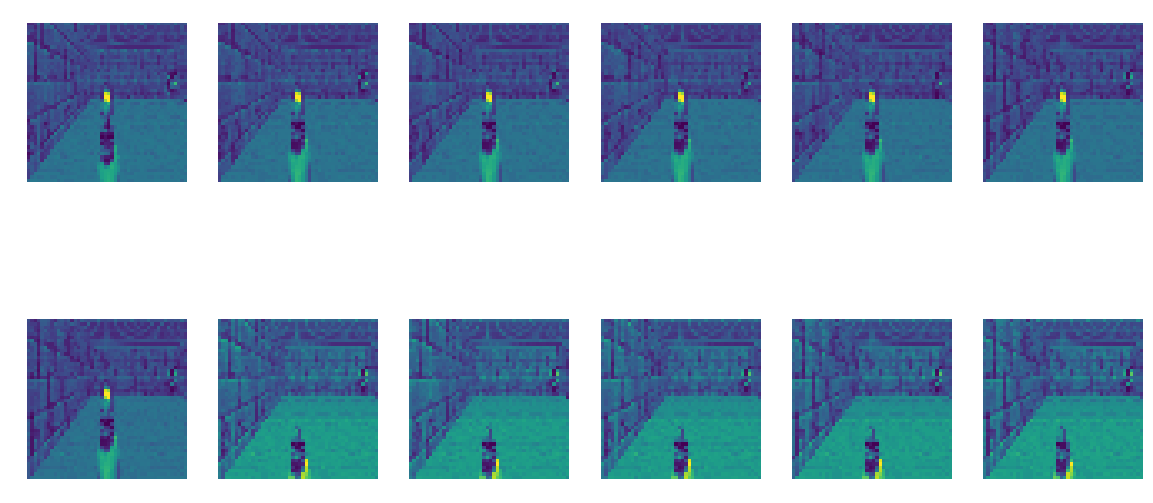

In [21]:
n_frames = 6 # per row
n_rows = 2
ixs = reversed(range(len(frames)-(n_frames*n_rows), len(frames)))
fig, axs = plt.subplots(ncols=n_frames, nrows=n_rows, figsize=(20, 10))
for coord, ix in enumerate(ixs):
    coord = np.unravel_index(coord, dims=(n_rows, n_frames)) # there must be a simpler way
    axs[coord].axis('off')
    axs[coord].imshow(frames[ix])
    axs[coord].set_title('Frame: ' + str(ix) + ' Action: ' + str(labels[ix]))

The goal of the NN is to predict the sequence of actions played, given a short part of the episode replay. To each frame we stack the 5 next ones (for a total of six) and annotate the corresponding action as the one from the first frame.

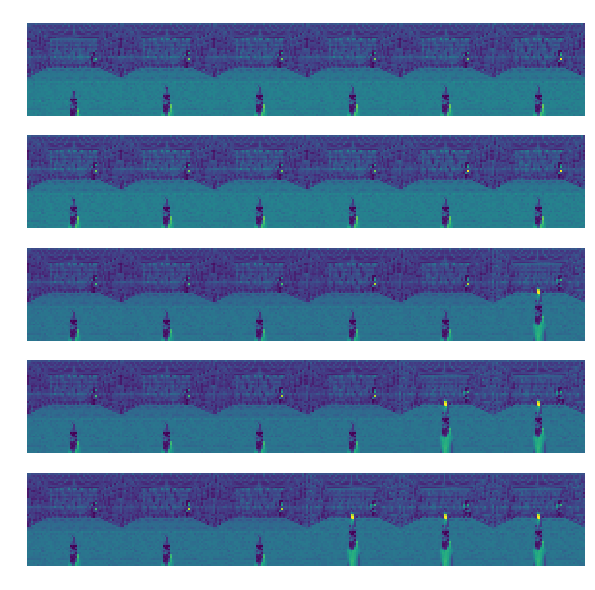

In [6]:
history_length = 6
stacks = [np.hstack(frames[ix:ix+history_length]) 
          for ix in range(len(frames)- history_length)]
fig, axs = plt.subplots(nrows=5, figsize=(10, 10))
for ix, ax in enumerate(axs):
    ax.axis('off')
    ax.set_title('Action: '+str(labels[ix]))
    ax.imshow(stacks[ix])

In [26]:
stacks[0].shape

(48, 288)

In [27]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 288, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 46, 286, 32)       320       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 23, 143, 32)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 21, 141, 32)       9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 10, 70, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 8, 68, 32)         9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 2, 22, 32)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1408)              0         
__________

In [15]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])